# Logistic Regression and Gradient Descent Homework Solutions
- In this homework we study **titanic** dataset using logistic regression 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn import linear_model
import matplotlib.pyplot as plt

In [2]:
titanic = pd.read_csv('data/Titanic.csv', index_col=0)
titanic.shape

FileNotFoundError: [Errno 2] File b'data/Titanic.csv' does not exist: b'data/Titanic.csv'

In [3]:
titanic.head()

,Name,PClass,Age,Sex,Survived,SexCode
1,"Allen, Miss Elisabeth Walton",1st,29.00,female,1,1
2,"Allison, Miss Helen Loraine",1st,2.00,female,0,1
3,"Allison, Mr Hudson Joshua Creighton",1st,30.00,male,0,0
4,"Allison, Mrs Hudson JC (Bessie Waldo Daniels)",1st,25.00,female,0,1
5,"Allison, Master Hudson Trevor",1st,0.92,male,1,0


## Question 1
### Part A - Missing Values Imputation

- Check if there are missing values
- It turns out only **Age** column has missing values
- There is a unique sample with PClass='*', sexCode=0 and no age information
- Remove this sample from the titanic dataframe
- Store the Survived column into a pandas series
- Create a new data frame using the 'PClass', 'SexCode', 'Age' columns (don't forget to use .copy() to create a copy with fresh memory)
- We would like to impute the missing **Age** values using the means of the corresponding 'PClass', 'SexCode' groups which the samples fall in
- ${\bf Hint}$: One way to impute using the result of groupby is 
    - converting the groupby result into a dictionary using to_dict method
    - using panda series **apply** method on a lambda function, where the lambda function is defined using the above dictionary
    
- ${\bf Remark}$: **SexCode** is the binary integer encoding of gender    

In [4]:
titanic.isnull().sum(axis=0)

Name          0
PClass        0
Age         557
Sex           0
Survived      0
SexCode       0
dtype: int64

In [5]:
titanic1 = titanic.copy()
titanic1 = titanic1[titanic1.PClass !='*']

In [6]:
Survived = titanic1.Survived
titanic2 = titanic1[['PClass', 'SexCode', 'Age']].copy()

In [7]:
imputation_dict = titanic2.groupby(['PClass', 'SexCode']).mean().to_dict()
imputation_dict['Age']

{('1st', 0): 41.19936,
 ('1st', 1): 37.772277227722775,
 ('2nd', 0): 28.910472440944883,
 ('2nd', 1): 27.388235294117646,
 ('3rd', 0): 26.357222222222223,
 ('3rd', 1): 22.776176470588236}

In [8]:
titanic2.sample(5)

,PClass,SexCode,Age
432,2nd,0,43.0
816,3rd,1,38.0
759,3rd,0,NaN
128,1st,0,25.0
370,2nd,0,29.0


In [9]:
impute_index = titanic2.Age.isnull()
titanic2.loc[impute_index, 'Age'] = titanic2[impute_index].apply(lambda x:imputation_dict['Age'][(x[0], x[1])], axis=1)

In [10]:
# Verify there is no missing Age values any more
titanic2.isnull().sum(axis=0)

PClass     0
SexCode    0
Age        0
dtype: int64

## Part B
- The **PClass** column can be treated as an ordinal categorical column.  If so,  we only need to convert the string values into
integer labels
- Alternatively, one can treat **PClass** as a nominal categorical column and dummify it
- In either way, fit a logistic regression model and compute its accuracy
- Set the logistic regression model hyperparameter $C$ to $1e4$ to disable **Ridge** penality

In [11]:
titanic2.PClass = titanic2.PClass.map(lambda t:int(t[0]))

In [12]:
Survived.value_counts() # about 1/3 of the passengers survive

0    862
1    450
Name: Survived, dtype: int64

In [13]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression(C=1e4, solver='lbfgs', multi_class='auto')
logistic.fit(titanic2, Survived)
logistic.score(titanic2, Survived)

0.8155487804878049

In [14]:
U = pd.get_dummies(titanic2['PClass'], prefix='Class')
titanic_dummified = pd.concat((U.drop('Class_1',axis=1), titanic2[['Age', 'SexCode']]), axis=1)

In [15]:
logistic.fit(titanic_dummified, Survived)
logistic.score(titanic_dummified, Survived)

0.8163109756097561

## Part C
- In this part we use the features 'Age', 'SexCode', 'Survived' to predict the multiclass labels **PClass**
- Fit a logistic regression model through the default **ovr** ensembling technique and study its performance
- Among the three values of **PClass**, which class has the worse performance?

- ${\bf Hint}$: the **confusion_matrix** function in **sklearn.metrics** helps to discern the discrepancy of the true labels and predicted labels. It is used as confusion_matrix(true_label_series, predict_label_series)

In [16]:
X = titanic2[['Age', 'SexCode']].copy()
X['Survived'] = Survived
Y = titanic2['PClass']

In [17]:
logistic.fit(X,Y)
logistic.score(X, Y)

0.6570121951219512

- Very low accuracy, which class causes the poor performance?
- We investigate the class-by-class performance using confusion_matrix
- Visit http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html for a description

In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y, logistic.predict(X))

array([[200,   0, 122],
       [ 68,  19, 192],
       [ 68,   0, 643]], dtype=int64)

In [19]:
Y.value_counts()

3    711
1    322
2    279
Name: PClass, dtype: int64

- Because class $2$ has $279$ samples, it is class $2$ which is completely mis-classified by logistic regression classifier

## Question 2

In [20]:
from sklearn.linear_model import SGDClassifier

## Part A
- Train a gradient descent logistic regression model by setting the parameters of an **sgd** object properly
- The loss is specified to 'log' for **logistic regression**
- Notice that we turn **shuffle** to False to prevent randomness
- Setting $\alpha=0.0001$ is equivalent to setting $C=10000$ for the logisticRegression model
- Fit a gradient descent logistic regression with the binary labels **Survived** on 'Age', 'SexCode', 'PClass' and compute its accuracy
- Fit a gradient descent logistic regression with the 3-class **PClass** labels on 'Age', 'SexCode', 'Survived' and compute its accuracy

In [21]:
sgd = SGDClassifier(loss='log', max_iter=1e4, l1_ratio=0, alpha=1e-4, shuffle=False)

In [22]:
sgd.fit(titanic2, Survived)
sgd.score(titanic2, Survived)

0.7972560975609756

In [23]:
sgd.fit(X,Y)
sgd.score(X,Y)

0.5411585365853658

## Part B
- Now turn on the **shuffle** flag to True and repeat what you did in Part A
- Run a for loop iterating through range(10) and store the accuracies into a list
- Plot the accuracies and verify that they are quite random

In [24]:
np.random.seed(0)
sgd.set_params(shuffle=True)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0, learning_rate='optimal', loss='log', max_iter=10000.0,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Text(0, 0.5, 'accuracy score')

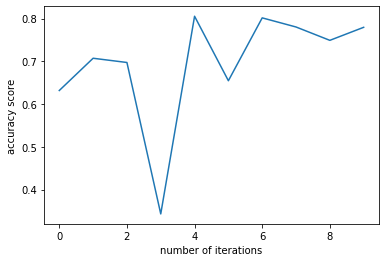

In [25]:
scores_binary = []
for i in range(10):
    sgd.fit(titanic2, Survived)
    scores_binary.append(sgd.score(titanic2, Survived))

plt.plot(range(10), scores_binary) 
plt.xlabel('number of iterations')
plt.ylabel('accuracy score')

Text(0, 0.5, 'accuracy score')

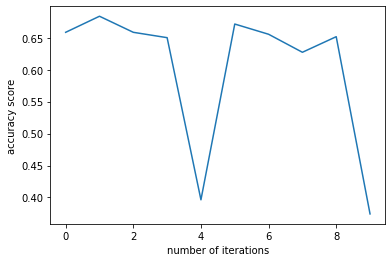

In [26]:
scores_PClass = []
for i in range(10):
    sgd.fit(X,Y)
    scores_PClass.append(sgd.score(X,Y))

plt.plot(range(10), scores_PClass)
plt.xlabel('number of iterations')
plt.ylabel('accuracy score')

## Part C
- Set **max_iter=None** and **tol=1e-6** through **set_params** **API**, then repeat the same computation as in part B
- What do you observe with the variations of accuracies?

In [27]:
sgd.set_params(tol=1e-6)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0, learning_rate='optimal', loss='log', max_iter=10000.0,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=1e-06,
              validation_fraction=0.1, verbose=0, warm_start=False)

Text(0, 0.5, 'accuracy score')

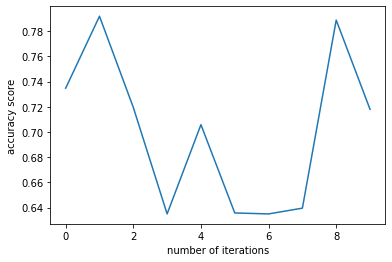

In [28]:
scores_binary = []
for i in range(10):
    sgd.fit(titanic2, Survived)
    scores_binary.append(sgd.score(titanic2, Survived))

plt.plot(range(10), scores_binary)    
plt.xlabel('number of iterations')
plt.ylabel('accuracy score')

Text(0, 0.5, 'accuracy score')

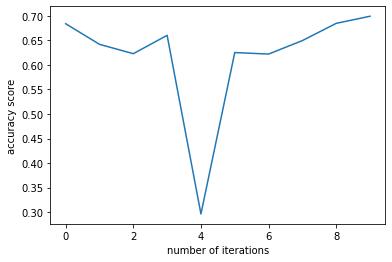

In [29]:
scores_PClass = []
for i in range(10):
    sgd.fit(X,Y)
    scores_PClass.append(sgd.score(X,Y))

plt.plot(range(10), scores_PClass)
plt.xlabel('number of iterations')
plt.ylabel('accuracy score')

## Remark:
- For both computations, the accuracies vary a lot during the $10$ iterations
- This shows that early stopping based on tolerance can lead to insufficient number of iterations, which causes the
performance to swing wildly